In [1]:
import sys
sys.path.append("../segmentation_models")
sys.path.append("../classification_models")

import collections
import cv2 
import glob
import keras
import numpy as np
import os
import classification_models
import segmentation_models
import matplotlib.pyplot as plt
from scipy import io
from sklearn.preprocessing import normalize
from keras.layers import Dense
from keras.optimizers import Adam
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

Using TensorFlow backend.
../classification_models/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [2]:
# Create UNet model with custom resnet weights
model = Unet('resnet50', 
             classes=2, 
             input_shape=(512, 512, 3), 
             encoder_weights='imagenet', 
             activation='softmax')


/home/ryansullivan/Documents/sullivan_ryan
Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#model.summary()

In [4]:
model.compile(optimizer=Adam(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
input_size = (512,512)

def load_image(path):
    """Load grayscale image from path"""
    return cv2.resize(cv2.imread(path,1), input_size)

def load_binary_image(path):
    """Load grayscale image from path"""
    return cv2.resize(cv2.imread(path,0), input_size)

def load_mat(path):
    """Load grayscale image from path"""
    image = io.loadmat(path, appendmat=False)['dxImage']['img'][0][0]
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    colored_image = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2RGB)
    return cv2.resize(colored_image, input_size)

def load_mask_mat(path):
    """Load grayscale image from path"""
    image = io.loadmat(path, appendmat=False)['maskImage'][0][0][0][0][0].astype(np.float32)
    scaled_image = cv2.resize(image, input_size)
    reshaped_image = np.reshape(scaled_image, (input_size[0], input_size[1], 1))
    split_channel_image = np.append(reshaped_image, 1 - reshaped_image, axis=2)
    return split_channel_image

X = []
Y = []
data_dir = "/data/midi-lab-general/osemis_annotations/osemis_annotation_file_to_masks/Masks/*.mat"
for filepath in sorted(glob.glob(data_dir, recursive=True)):
    if filepath.endswith("image.mat"):
        X.append(load_mat(filepath))
    if filepath.endswith("mask.mat"):
        Y.append(load_mask_mat(filepath))
X = np.reshape(np.array(X), (-1, input_size[0], input_size[1], 3))
Y = np.reshape(np.array(Y), (len(X), input_size[0], input_size[1], 2))

line_ratio = 0
for image in Y[:,:,:,0]:
    image = np.round(image, decimals=0)
    unique, counts = np.unique(image, return_counts=True)
    d = dict(zip(unique, counts))
    print(d)
    line_ratio += d[1.0]/(d[1.0] + d[0.0])
print(line_ratio/len(Y))

{0.0: 259693, 1.0: 2451}
{0.0: 261501, 1.0: 643}
{0.0: 261367, 1.0: 777}
{0.0: 259538, 1.0: 2606}
{0.0: 261122, 1.0: 1022}
{0.0: 260168, 1.0: 1976}
{0.0: 261180, 1.0: 964}
{0.0: 261213, 1.0: 931}
{0.0: 261420, 1.0: 724}
{0.0: 261205, 1.0: 939}
{0.0: 261453, 1.0: 691}
{0.0: 260817, 1.0: 1327}
{0.0: 261364, 1.0: 780}
{0.0: 259921, 1.0: 2223}
{0.0: 259878, 1.0: 2266}
{0.0: 260208, 1.0: 1936}
{0.0: 259856, 1.0: 2288}
{0.0: 259155, 1.0: 2989}
{0.0: 259557, 1.0: 2587}
{0.0: 259926, 1.0: 2218}
{0.0: 259841, 1.0: 2303}
{0.0: 259150, 1.0: 2994}
{0.0: 259769, 1.0: 2375}
{0.0: 260015, 1.0: 2129}
{0.0: 257311, 1.0: 4833}
{0.0: 259915, 1.0: 2229}
{0.0: 259180, 1.0: 2964}
{0.0: 260844, 1.0: 1300}
{0.0: 256322, 1.0: 5822}
{0.0: 259501, 1.0: 2643}
{0.0: 258962, 1.0: 3182}
{0.0: 259855, 1.0: 2289}
{0.0: 260204, 1.0: 1940}
{0.0: 260209, 1.0: 1935}
{0.0: 260162, 1.0: 1982}
{0.0: 260084, 1.0: 2060}
{0.0: 259205, 1.0: 2939}
{0.0: 260148, 1.0: 1996}
{0.0: 260316, 1.0: 1828}
{0.0: 259572, 1.0: 2572}
{0.0: 25

68 Samples; 47 train; 10 val; 11 test
(512, 512, 3)


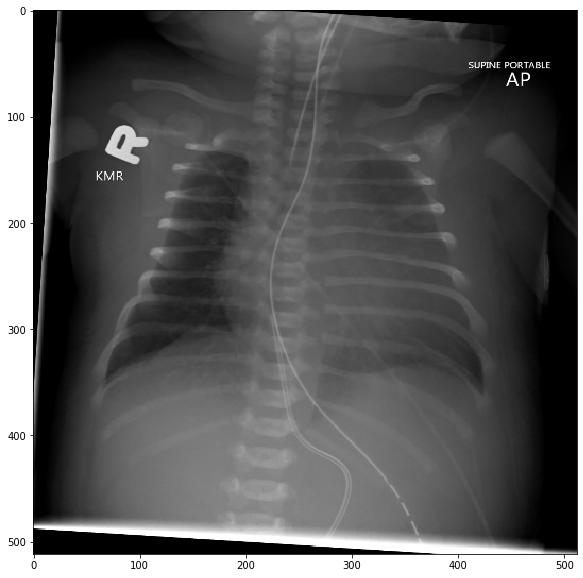

In [15]:
val_split = 0.15
test_split = 0.15
n = len(X)
sp1 = int(((1 - val_split - test_split) * n) - 0.5) # Choose first index with rounding adjustment (0.5)
sp2 = int(((1 - test_split) * n) - 0.5) # Choose second index with rounding adjustment (0.5)
X_train, Y_train = X[:sp1], Y[:sp1]
X_val, Y_val = X[sp1:sp2], Y[sp1:sp2]
X_test, Y_test = X[sp2:], Y[sp2:]
print("{} Samples; {} train; {} val; {} test".format(n, len(X_train), len(X_val), len(X_test)))
def plot_sample(sample, figsize=(10,10)):
    print(sample.shape)
    sample = np.squeeze(sample)
    plt.figure(figsize=figsize)
    plt.imshow(sample, cmap='gray')
    plt.show()
plot_sample(X[1])

In [7]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=8, epochs=50, verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 18 samples, validate on 6 samples
Epoch 1/50
18/18 [==============================] - 15s 839ms/step - loss: 0.8624 - acc: 0.4982 - val_loss: 1.7570 - val_acc: 0.4685
Epoch 2/50
18/18 [==============================] - 1s 52ms/step - loss: 0.7350 - acc: 0.5873 - val_loss: 1.2246 - val_acc: 0.5933
Epoch 3/50
18/18 [==============================] - 1s 52ms/step - loss: 0.6304 - acc: 0.7221 - val_loss: 0.9207 - val_acc: 0.7098
Epoch 4/50
18/18 [==============================] - 1s 52ms/step - loss: 0.5351 - acc: 0.8370 - val_loss: 0.7573 - val_acc: 0.7631
Epoch 5/50
18/18 [==============================] - 1s 52ms/step - loss: 0.4639 - acc: 0.9016 - val_loss: 0.6265 - val_acc: 0.7991
Epoch 6/50
18/18 [==============================] - 1s 52ms/step - loss: 0.4138 - acc: 0.9387 - val_loss: 0.4863 - val_acc: 0.8471
Epoch 7/50
18/18 [=========================

KeyboardInterrupt: 

In [8]:
model.evaluate(X_test, Y_test)

6/6 [==============================] - 0s 16ms/step


[0.15432535111904144, 0.9910430908203125]

(512, 512, 3)
[[[[0.3166062  0.68339384]
   [0.2184356  0.7815644 ]
   [0.22917736 0.77082264]
   ...
   [0.19417894 0.805821  ]
   [0.22817668 0.7718233 ]
   [0.28193894 0.71806103]]

  [[0.27790102 0.722099  ]
   [0.14483038 0.85516965]
   [0.1551775  0.84482247]
   ...
   [0.10693277 0.89306724]
   [0.15050194 0.84949803]
   [0.25268272 0.74731725]]

  [[0.28315252 0.7168475 ]
   [0.15438335 0.8456167 ]
   [0.19487247 0.80512756]
   ...
   [0.11967275 0.8803272 ]
   [0.1694597  0.8305403 ]
   [0.30825117 0.6917488 ]]

  ...

  [[0.27881566 0.7211843 ]
   [0.14423937 0.85576063]
   [0.22386393 0.77613604]
   ...
   [0.32391784 0.6760822 ]
   [0.38225457 0.61774546]
   [0.37177864 0.6282214 ]]

  [[0.32597816 0.67402184]
   [0.18050417 0.8194958 ]
   [0.29009268 0.7099073 ]
   ...
   [0.21541086 0.7845891 ]
   [0.2819035  0.7180965 ]
   [0.3554354  0.64456457]]

  [[0.31199294 0.688007  ]
   [0.24178687 0.75821316]
   [0.261808   0.738192  ]
   ...
   [0.28588682 0.7141132 ]
   [0.275

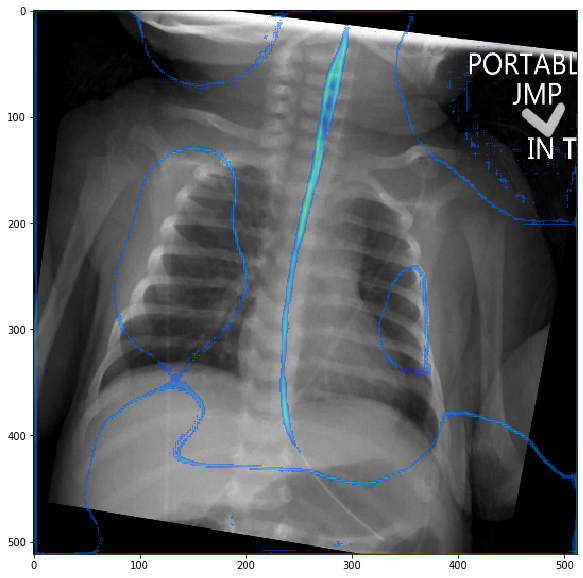

In [12]:
def plot_mask(sample, mask, figsize=(10,10)):
    print(sample.shape)
    print(mask)
    mask = np.squeeze(mask)
    plt.figure(figsize=figsize)
    plt.imshow(sample, cmap='gray')
    plt.imshow(np.ma.masked_where(mask[:, :, 0] < 0.2, mask[:, :, 0]), cmap='jet', alpha=0.5, vmin=0, vmax=1)
    plt.show()

predicted_mask = model.predict(np.expand_dims(X_test[2], axis=0))
plot_mask(X_test[2], predicted_mask)